# **Описание**

In [1]:
from __future__ import division

import base64
import csv
import gzip
import zlib

from collections import namedtuple
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import pymorphy2
from collections import Counter

%matplotlib inline
import matplotlib.pyplot as plt

import sys
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from catboost import CatBoostClassifier
import xgboost as xgb
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
from multiprocessing.dummy import Pool as ThreadPool

In [2]:
TRACE_NUM = 1000
import logging
import importlib
importlib.reload(logging)
logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', level=logging.INFO, datefmt='%H:%M:%S')

def trace(items_num, trace_num=TRACE_NUM):
    if items_num % trace_num == 0: logging.info("Complete items %05d" % items_num)
        
def trace_worker(items_num, worker_id, trace_num=TRACE_NUM):
    if items_num % trace_num == 0: logging.info("Complete items %05d in worker_id %d" % (items_num, worker_id))

### Утилиты

#### Декораторы

In [3]:
def to_utf8(text):
    if isinstance(text, unicode): text = text.encode('utf8')
    return text

def convert2unicode(f):
    def tmp(text):
        if not isinstance(text, unicode): text = text.decode('utf8')
        return f(text)
    return tmp

def convert2lower(f):
    def tmp(text):        
        return f(text.lower())
    return tmp

# #P.S. Декораторы могут усложнять отладку, так что от них вполне можно отказаться и воспользоваться copy-paste

### Извлечение текста из html

#### Извлечение текста при помощи встроенных модулей

In [4]:
from html.parser import HTMLParser
import re

###Извлечение текста из title можно вписать сюда

class TextHTMLParser(HTMLParser):
    def __init__(self):
        HTMLParser.__init__(self)
        self._text = []
        self._title = ""
        self._in_title = False

    def handle_data(self, data):
        text = data.strip()
        if len(text) > 0:
            text = re.sub('[ \t\r\n]+', ' ', text)
            self._text.append(text + ' ')

    def handle_starttag(self, tag, attrs):
        if tag == 'p':
            self._text.append('\n\n')
        elif tag == 'br':
            self._text.append('\n')
        elif tag == 'title':
            self._in_title = True

    def handle_startendtag(self, tag, attrs):
        if tag == 'br':
            self._text.append('\n\n')

    def text(self):
        return ''.join(self._text).strip()

def html2text_parser(text):
    parser = TextHTMLParser()
    parser.feed(text)
    return parser.text()

#### Извлечение текста при помощи дополнительных библиотек

In [5]:
def html2text_bs(raw_html):
    from bs4 import BeautifulSoup
    """
    Тут производится извлечения из html текста
    """
    soup = BeautifulSoup(raw_html, "html.parser")
    [s.extract() for s in soup(['script', 'style'])]
    return soup.get_text()

def html2text_bs_visible(raw_html):
    from bs4 import BeautifulSoup
    """
    Тут производится извлечения из html текста, который видим пользователю
    """
    soup = BeautifulSoup(raw_html, "html.parser")    
    [s.extract() for s in soup(['style', 'script', '[document]', 'head', 'title'])]
    return soup.get_text()


#### Выбираем какой метод для конвертации html в текст будет основным

In [6]:
#html2text = html2text_bs
html2text = html2text_parser

#### Методы для токенизации текста

In [7]:
def easy_tokenizer(text):
    word = str()
    for symbol in text:
        if symbol.isalnum(): word += symbol
        elif word:
            yield word
            word = str()
    if word: yield word

PYMORPHY_CACHE = {}
MORPH = None
#hint, чтобы установка pymorphy2 не была бы обязательной
def get_lemmatizer():
    import pymorphy2
    global MORPH
    if MORPH is None: MORPH = pymorphy2.MorphAnalyzer()
    return MORPH

def pymorphy_tokenizer(text):
    global PYMORPHY_CACHE
    for word in easy_tokenizer(text):
        word_hash = hash(word)
        if word_hash not in PYMORPHY_CACHE:
            PYMORPHY_CACHE[word_hash] = get_lemmatizer().parse(word)[0].normal_form            
        yield PYMORPHY_CACHE[word_hash]

get_lemmatizer()

#### Основная функция, которая вызывается для преобразования html в список слов

In [8]:
def html2word(raw_html, to_text=html2text, tokenizer=easy_tokenizer):
    return tokenizer(to_text(raw_html).lower())

#### Рассчет финальных метрик

In [9]:
def safe_divide(a, b):
    if a == 0: return 0.0
    elif b == 0: return 0.0
    else: return a/b

def calculate_metrics(predictions, threshold):    
    """
    Функция подсчета метрик
    Параметры
    predictions - ранки по документам
    threshold  - порог для метрик
    """
    true_positive = 0
    false_positive = 0
    true_negative = 0
    false_negative = 0
    for (url_id, mark, url, prediction) in predictions:        
        mark_predict = prediction > threshold

        if mark_predict:                     
            if mark_predict == mark: true_positive += 1
            else: false_positive += 1                    
        else:                     
            if  mark_predict == mark: true_negative += 1
            else: false_negative += 1

    class_prec  = safe_divide(true_positive, true_positive + false_positive)
    class_recall = safe_divide(true_positive, true_positive + false_negative)
        
    class_F1 = safe_divide(2 * class_prec * class_recall, class_prec + class_recall)
    
    
    not_class_prec = safe_divide(true_negative, true_negative + false_negative)
    not_class_recall = safe_divide(true_negative, true_negative + false_positive)
    
    not_class_F1 = safe_divide(2 * not_class_prec * not_class_recall, not_class_prec + not_class_recall)
    
    return ( (class_prec, class_recall, class_F1), (not_class_prec, not_class_recall, not_class_F1) )

def arange(start, stop, step):
    cur_value = start
    while True:
        if cur_value > stop: break
        yield cur_value
        cur_value += step

def plot_results(docs, min_threshold=-1, max_threshold=1, step=0.1, trace=False):
    x = []
    y_p = []
    y_n = []
    docs_predictions = classifier.predict_all(docs)
    for threshold in arange(min_threshold, max_threshold, step):
        r = calculate_metrics(docs_predictions, threshold)
        x.append(threshold)
        y_p.append(r[0])
        y_n.append(r[1])        
        if trace: 
            print('threshold %s' % threshold)
            print('\tclass_prec %s, class_recall %s, class_F1 %s' % r[0])
            print('\tnot_class_prec %s, not_class_recall %s, not_class_F1 %s' % r[1])
            print('\t\tMacroF1Mesure %s' % ((r[0][2] + r[1][2])/2))
    plot_stats(x, y_p, "Class Result")
    plot_stats(x, y_n, "Not class Result")    


def plot_stats(x, y, title):
    plt.figure(figsize=(10, 5))

    prec, = plt.plot( x, 
                     [k[0] for k in y], "r", label='Precision', 
                     linewidth=1)
    accur, = plt.plot( x, 
                      [k[1] for k in y], "b", label='Recall',
                      linewidth=1)
    f1, =    plt.plot( x, 
                      [k[2] for k in y], "g", label='F1',
                      linewidth=1)
    plt.grid(True)
    plt.legend(handles=[prec, accur, f1])
    plt.title(title)
    plt.show()

In [10]:
def calc_features(url, html_data):
    soup = BeautifulSoup(html_data, 'html.parser')
    words = list(html2word(html_data))
    
    ## Amount of words
    words_num = len(words)
    ## Average word length
    avg_word_len = np.mean([len(word) for word in words])
    ## Title word num
    title = soup.find('title')
    if title is not None:
        title = title.text
        title_words_num = len(title.strip().split(' '))
    else:
        title_words_num = 0
    ## Nwords in acnhor
    anchor_words_num = len(re.findall(r"/\w+", url))
    ## Compression_level
    compression_level = len(zlib.compress(html_data.encode("utf-8")))
    ## Number of urls in text
    anchor_num = len(soup.find_all('a'))
    ## Url length
    anchor_len = len(url)
    ## Nunique words, maximum frequence of word
    len_html = len(html_data)
    img_cnt = len(soup.find_all('img'))

    descr = soup.find('meta', {"name":"description"})
    title_len = 0
    if descr is not None:
        if 'content' in descr.attrs:
            title_len = len(descr['content'])

    return [words_num, avg_word_len, title_words_num, anchor_words_num,
            compression_level, anchor_len, len_html,
            img_cnt, title_len, anchor_num, html2text(html_data)]


In [11]:
test_html_data = u'''
<html>
<title> Заголовок Ololo </title>
<meta name="description" content="Сайт об HTML и создании сайтов"> 
спам 1 2 3
котиком котом котярой и кот
</html>
'''
test_url = 'http://ololo/c'
test_features = calc_features(test_url, test_html_data)
print(test_features)

[11, 4.0, 2, 2, 171, 14, 156, 0, 30, 0, 'Заголовок Ololo спам 1 2 3 котиком котом котярой и кот']


In [12]:
from multiprocessing import Process, Queue

DocItem = namedtuple('DocItem', ['doc_id', 'is_spam', 'url', 'features'])

WORKER_NUM = 4

def load_csv(input_file_name, calc_features_f):    
    """
    Загружаем данные и извлекаем на лету признаки
    Сам контент не сохраняется, чтобы уменьшить потребление памяти - чтобы
    можно было запускать даже на ноутбуках в классе
    """
    global LAST_HTML
    with gzip.open(input_file_name, mode='rt', encoding='utf8') if input_file_name.endswith('gz') else open(input_file_name, mode='rt', encoding='utf8')  as input_file:            
        headers = input_file.readline()
        
        for i, line in enumerate(input_file):
            trace(i)
            parts = line.strip().split('\t')
            url_id = int(parts[0])                                        
            mark = bool(int(parts[1]))                    
            url = parts[2]
            pageInb64 = parts[3]
            html_data = base64.b64decode(pageInb64)
            try:
                html_data = html_data.decode('utf8')
            except:
                html_data = html_data.decode('latin1')
            features = calc_features_f(url, html_data)            
            yield DocItem(url_id, mark, url, features)            
                
        trace(i, 1)  
        
def load_csv_worker(input_file_name, calc_features_f, worker_id, res_queue):    
    with gzip.open(input_file_name,  mode='rt', encoding='utf8') if input_file_name.endswith('gz') else open(input_file_name, mode='rt', encoding='utf8')  as input_file:            
        headers = input_file.readline()
        
        for i, line in enumerate(input_file):
            trace_worker(i, worker_id)
            if i % WORKER_NUM != worker_id: continue
            parts = line.strip().split('\t')
            url_id = int(parts[0])                                        
            mark = bool(int(parts[1]))                    
            url = parts[2]
            pageInb64 = parts[3]
            html_data = base64.b64decode(pageInb64)
            try:
                html_data = html_data.decode('utf8')
            except:
                html_data = html_data.decode('latin1')
            features = calc_features_f(url, html_data)            
            res_queue.put(DocItem(url_id, mark, url, features))
                
        trace_worker(i, worker_id, 1)  
    res_queue.put(None)
        
def load_csv_multiprocess(input_file_name, calc_features_f):
    processes = []
    res_queue = Queue()    
    for i in range(WORKER_NUM):
        process = Process(target=load_csv_worker, args=(input_file_name, calc_features_f, i, res_queue))
        processes.append(process)
        process.start()
    
    complete_workers = 0
    while complete_workers != WORKER_NUM:
        item = res_queue.get()
        if item is None:
            complete_workers += 1
        else:
            yield item
        
    for process in processes: process.join()

** Обрабатываем входной файл **
<br>
Формат - поля разделенные табуляциями
<br>
0 - идентификатор документа
<br>
1 - метка класса 0 - не спам, 1 - спам
<br>
2 - урл документа
<br>
3 - документ в кодировке base64

Выходной формат - массив кортежей вида
(doc_id, is_spam, url, html_data)

In [13]:
%%time

TRAIN_DATA_FILE  = 'kaggle_train_data_tab.csv'
# TRAIN_DATA_FILE  = 'kaggle_train_data_tab.csv.gz'
train_docs = list(load_csv_multiprocess(TRAIN_DATA_FILE, calc_features))
# train_docs = list(load_csv(TRAIN_DATA_FILE, calc_features))
# ololo = load_csv(TRAIN_DATA_FILE, calc_features)
TEST_DATA_FILE  = 'kaggle_test_data_tab.csv'
# TEST_DATA_FILE  = 'kaggle_test_data_tab.csv.gz'
test_docs = list(load_csv_multiprocess(TEST_DATA_FILE, calc_features))

03:29:04 INFO:Complete items 00000 in worker_id 0
03:29:04 INFO:Complete items 00000 in worker_id 1
03:29:04 INFO:Complete items 00000 in worker_id 2
03:29:04 INFO:Complete items 00000 in worker_id 3
03:29:24 INFO:Complete items 01000 in worker_id 0
03:29:26 INFO:Complete items 01000 in worker_id 2
03:29:26 INFO:Complete items 01000 in worker_id 3
03:29:31 INFO:Complete items 01000 in worker_id 1
03:29:45 INFO:Complete items 02000 in worker_id 0
03:29:47 INFO:Complete items 02000 in worker_id 2
03:29:47 INFO:Complete items 02000 in worker_id 3
03:29:50 INFO:Complete items 02000 in worker_id 1
03:30:05 INFO:Complete items 03000 in worker_id 0
03:30:09 INFO:Complete items 03000 in worker_id 3
03:30:10 INFO:Complete items 03000 in worker_id 1
03:30:10 INFO:Complete items 03000 in worker_id 2
03:30:24 INFO:Complete items 04000 in worker_id 0
03:30:26 INFO:Complete items 04000 in worker_id 2
03:30:29 INFO:Complete items 04000 in worker_id 3
03:30:29 INFO:Complete items 04000 in worker_id 1


CPU times: user 5.21 s, sys: 873 ms, total: 6.09 s
Wall time: 10min 42s


In [15]:
from tqdm import tqdm
text = []
for doc in tqdm(train_docs):
    text.append(doc.features[-1])
for doc in tqdm(test_docs):
    text.append(doc.features[-1])


100%|██████████| 16039/16039 [00:00<00:00, 1401976.53it/s]


In [57]:
v1 = TfidfVectorizer(max_features=700).fit(text)
#v2 = TfidfVectorizer(max_features=100).fit(itext)

In [58]:
res1 = v1.transform(text)
#res2 = v2.transform(itext)

In [59]:
res1 = res1.toarray()
#res2 = res2.toarray()

In [60]:
X, y = [], []

In [61]:
for i, doc in enumerate(train_docs):
    if doc[1]:
        y.append([0, 1])
    else:
        y.append([1, 0])
    X.append(np.concatenate((list(doc.features[:-1]), res1[i])))

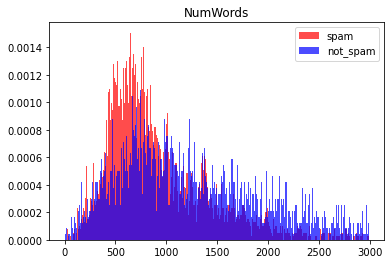

In [150]:
is_spam_data = [doc.features[0] for doc in train_docs if doc[1] == True]
not_spam_data = [doc.features[0] for doc in train_docs if doc[1] == False]
bins = range(0,3000,10)
plt.hist(is_spam_data, bins=bins, color='red', density=True, alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=bins, color='blue', density=True, alpha=0.7, label='not_spam')
plt.title('NumWords')
plt.legend()
plt.show()

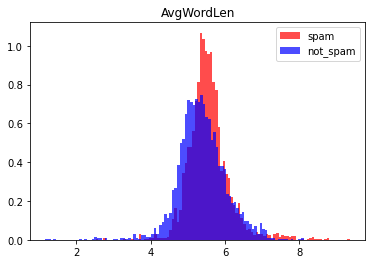

In [151]:
is_spam_data = [doc.features[1] for doc in train_docs if doc[1] == True]
not_spam_data = [doc.features[1] for doc in train_docs if doc[1] == False]
bins = 100
plt.hist(is_spam_data, bins=bins, color='red', density=True, alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=bins, color='blue', density=True, alpha=0.7, label='not_spam')
plt.title('AvgWordLen')
plt.legend()
plt.show()

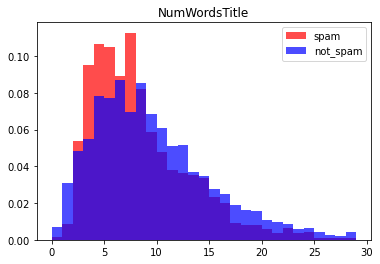

In [152]:
is_spam_data = [doc.features[2] for doc in train_docs if doc[1] == True]
not_spam_data = [doc.features[2] for doc in train_docs if doc[1] == False]
bins = range(0, 30, 1)
plt.hist(is_spam_data, bins=bins, color='red', density=True, alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=bins, color='blue', density=True, alpha=0.7, label='not_spam')
plt.title('NumWordsTitle')
plt.legend()
plt.show()

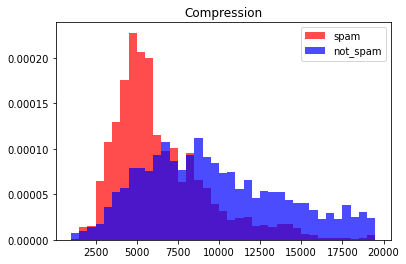

In [153]:
is_spam_data = [doc.features[4] for doc in train_docs if doc[1] == True]
not_spam_data = [doc.features[4] for doc in train_docs if doc[1] == False]
bins = range(1000, 20000, 500)
plt.hist(is_spam_data, bins=bins, color='red', density=True, alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=bins, color='blue', density=True, alpha=0.7, label='not_spam')
plt.title('Compression')
plt.legend()
plt.show()

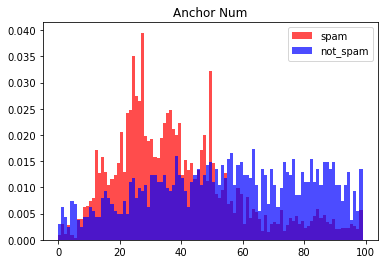

In [154]:
is_spam_data = [doc.features[-2] for doc in train_docs if doc[1] == True]
not_spam_data = [doc.features[-2] for doc in train_docs if doc[1] == False]
bins = range(0, 100)
plt.hist(is_spam_data, bins=bins, color='red', density=True, alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=bins, color='blue', density=True, alpha=0.7, label='not_spam')
plt.title('Anchor Num')
plt.legend()
plt.show()

**Классификатор:**
Нужно реализовать

In [43]:
#X = np.array(train_data[0])
#y = np.array(train_data[1])

In [23]:
#X = (X - np.mean(X, axis=1)[:, None]) / np.std(X, axis=1)[:, None]

In [62]:
#X = torch.Tensor(X).float()
#y = torch.Tensor(y)
X, y = shuffle(np.array(X), np.array(y))

In [63]:
clf = CatBoostClassifier().fit(X, y.argmax(axis=1))

Learning rate set to 0.023711
0:	learn: 0.6622735	total: 83.6ms	remaining: 1m 23s
1:	learn: 0.6381611	total: 146ms	remaining: 1m 12s
2:	learn: 0.6136423	total: 219ms	remaining: 1m 12s
3:	learn: 0.5911472	total: 322ms	remaining: 1m 20s
4:	learn: 0.5689255	total: 417ms	remaining: 1m 22s
5:	learn: 0.5510706	total: 483ms	remaining: 1m 20s
6:	learn: 0.5350460	total: 551ms	remaining: 1m 18s
7:	learn: 0.5135579	total: 652ms	remaining: 1m 20s
8:	learn: 0.4944636	total: 759ms	remaining: 1m 23s
9:	learn: 0.4801361	total: 868ms	remaining: 1m 25s
10:	learn: 0.4633994	total: 990ms	remaining: 1m 28s
11:	learn: 0.4524132	total: 1.1s	remaining: 1m 30s
12:	learn: 0.4428349	total: 1.21s	remaining: 1m 31s
13:	learn: 0.4314751	total: 1.32s	remaining: 1m 32s
14:	learn: 0.4209509	total: 1.42s	remaining: 1m 33s
15:	learn: 0.4089773	total: 1.49s	remaining: 1m 31s
16:	learn: 0.4003905	total: 1.56s	remaining: 1m 30s
17:	learn: 0.3906667	total: 1.64s	remaining: 1m 29s
18:	learn: 0.3802010	total: 1.74s	remaining:

In [64]:
y_preds = np.array([], dtype=int)
elems = np.array([], dtype=int)

In [65]:
X_test = []
elem0 = []
l = len(train_docs)

In [66]:
for i, doc in enumerate(test_docs):
    elem0.append(doc[0])
    X_test.append(np.concatenate((list(doc.features[:-1]), res1[l + i])))

In [67]:
X_test = np.asarray(X_test)
#X_test = (X_test - np.mean(X_test, axis=1)[:, None]) / np.std(X_test, axis=1)[:, None]
X_test.shape

(16039, 710)

In [68]:
y_preds = clf.predict(X_test)

In [69]:
y_preds.sum()

8316

In [70]:
threshold = 800

with open('my_submission.csv' , 'wt') as fout:
    writer = csv.writer(fout)
    writer.writerow(['Id','Prediction'])
    for i, item in enumerate(y_preds):
        prediction =  item
        writer.writerow([elem0[i], prediction])